In [ ]:
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/RPS/data/Rock-Paper-Scissors/train'
test_dir = '/content/drive/MyDrive/RPS/data/Rock-Paper-Scissors/test'

In [ ]:
labels=[["rock"],["paper"],["scissors"]]
labels=np.array(labels)
labels=labels.reshape(-1,1)
encoder = OneHotEncoder()
encoder.fit(labels)

OneHotEncoder()

In [ ]:
class RPSDataset(Dataset):
    def __init__(self,path,transform=None):
        
        self.path=path
        files_rock=os.listdir(path+"/rock")
        files_paper=os.listdir(path+"/paper")
        files_scissors=os.listdir(path+"/scissors")
        self.img=files_rock+files_paper+files_scissors
        self.labels=["rock"]*len(files_rock)+["paper"]*len(files_paper)+["scissors"]*len(files_scissors)
        self.transform=transform
        
    def __getitem__(self,index):
        selected_image_path=self.img[index]
        
        encoded_label=None
        label_str=self.labels[index]
        
        if(label_str=="rock"):
            encoded_label=0
        elif(label_str=="paper"):
            encoded_label=1
        elif(label_str=="scissors"):
            encoded_label=2
        else:
            pass
        
        #Fetch the image from directory
        img=Image.open(self.path+"/"+label_str+"/"+selected_image_path)
        #img=img.convert('L')
        
        
        encoded_label=np.array(encoded_label)
            
        #Apply transforms 
        if self.transform is not None:
            img=self.transform(img)
            
        mean, std = img.mean(), img.std()
        normalize = transforms.Normalize(mean, std)
        norm_tensor = normalize(img)
        #unnorm_tensor = norm_tensor * std + mean
        
        return norm_tensor,encoded_label
    
    def __len__(self):
        return(len(self.img))

In [ ]:
transform=transforms.Compose([
    transforms.Resize([100,100]),
    transforms.ToTensor()
])

In [ ]:
train_set=RPSDataset(train_dir,transform=transform)
test_set=RPSDataset(test_dir,transform=transform)

In [ ]:
g = torch.Generator()
#Creating loader with batch size of 64 images
train_loader=DataLoader(train_set, batch_size=64, num_workers=0,generator=g,shuffle=True)
test_loader=DataLoader(test_set, batch_size=64, num_workers=0,generator=g,shuffle=True)

torch.Size([64, 4, 100, 100]) torch.Size([64])
tensor(1)


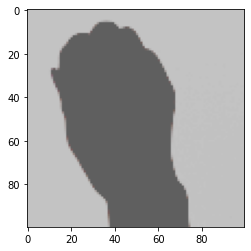

In [ ]:
#Checking the batch retrieval

images,label=next(iter(train_loader))
print(images.size(),label.shape)

#images -> The actual image tensors
#encoded_label -> one hot encoded label
#label -> actual text captcha label

#Display first image in the batch
plt.imshow(np.transpose(images[3].numpy(), (1, 2, 0)))
print(label[4]) #labels=[["rock"],["paper"],["scissors"]]

In [ ]:
class RPSCNN(nn.Module):
    
    def __init__(self):
        super(RPSCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(in_features=64*24*24, out_features=5000)
        self.fc2 = nn.Linear(in_features=5000, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=3)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out=nn.functional.log_softmax(out,dim=1)
        
        return out

In [ ]:
model = RPSCNN()

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

RPSCNN(
  (layer1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=36864, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


In [ ]:
num_epochs = 6
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

In [ ]:
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
#         images, labels = images.to(device), labels.to(device)
    
        train = Variable(images)
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        error = nn.CrossEntropyLoss()
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
        print("Epoch : ",epoch,"Iteration : ",count)
    
    # Testing the model
    
        if True:    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
            
            for images, labels in test_loader:
                labels_list.append(labels)
            
                test = Variable(images)
            
                outputs = model(test)
            
                _,predictions = torch.max(outputs.data,1)
                predictions_list.append(predictions)
                #print(predictions,labels)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Epoch :  1 Iteration :  76
Iteration: 76, Loss: 0.0014599148416891694, Accuracy: 71.7741928100586%
Epoch :  1 Iteration :  77
Iteration: 77, Loss: 0.0036565132904797792, Accuracy: 72.58064270019531%
Epoch :  1 Iteration :  78
Iteration: 78, Loss: 0.001276616589166224, Accuracy: 73.11827850341797%
Epoch :  1 Iteration :  79
Iteration: 79, Loss: 0.0015053546521812677, Accuracy: 72.8494644165039%
Epoch :  1 Iteration :  80
Iteration: 80, Loss: 0.0010137039935216308, Accuracy: 72.8494644165039%
Epoch :  2 Iteration :  81
Iteration: 81, Loss: 0.0011212804820388556, Accuracy: 72.58064270019531%
Epoch :  2 Iteration :  82
Iteration: 82, Loss: 0.00290858861990273, Accuracy: 72.8494644165039%
Epoch :  2 Iteration :  83
Iteration: 83, Loss: 0.0013095240574330091, Accuracy: 73.38710021972656%
Epoch :  2 Iteration :  84
Iteration: 84, Loss: 0.002398189390078187, Accuracy: 73.38710021972656%
Epoch :  2 Iteration :  85
Iteration: 85, Loss: 0.0017476819921284914, Accuracy: 73.38710021972656%
Epoch : 

In [ ]:
class ValidationDataset(Dataset):
    def __init__(self,path,transform=None):
        
        self.path=path
        self.img=os.listdir(path)
        self.transform=transform
        
    def __getitem__(self,index):
        selected_image_path=self.img[index]
        
        encoded_label=None
        
        if("rock" in selected_image_path):
            encoded_label=0
        elif("paper" in selected_image_path):
            encoded_label=1
        elif("scissors" in selected_image_path):
            encoded_label=2
        else:
            pass
        
        
        #Fetch the image from directory
        img=Image.open(self.path+"/"+selected_image_path)
        #img=img.convert('L')
        
        
        encoded_label=np.array(encoded_label)
            
        #Apply transforms 
        if self.transform is not None:
            img=self.transform(img)
            
        mean, std = img.mean(), img.std()
        normalize = transforms.Normalize(mean, std)
        norm_tensor = normalize(img)
        #unnorm_tensor = norm_tensor * std + mean
        
        return norm_tensor,encoded_label
    
    def __len__(self):
        return(len(self.img))

In [ ]:
validation_set=ValidationDataset('/content/drive/MyDrive/RPS/data/validation', transform=transform)
validation_loader=DataLoader(validation_set, batch_size=64, num_workers=0,generator=g,shuffle=True)

In [ ]:
total = 0
correct = 0

In [ ]:
for images, labels in validation_loader:
    labels_list.append(labels)
    test = Variable(images)
    outputs = model(test)
    _,predictions = torch.max(outputs.data,1)
    predictions_list.append(predictions)
    #print(predictions,labels)
    correct += (predictions == labels).sum()
    total += len(labels)
            
accuracy = correct * 100 / total
print("Accuracy: {}%".format(accuracy))

Accuracy: 87.8787841796875%


In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
def predict(path):
    
    img=Image.open(path)
    
    transform=transforms.Compose([
        transforms.Resize([100,100]),
        transforms.ToTensor()])

    #Apply transforms 
    if transform is not None:
        img=transform(img)
    
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            
    mean, std = img.mean(), img.std()
    normalize = transforms.Normalize(mean, std)
    norm_tensor = normalize(img)
    norm_tensor.unsqueeze_(0)
    input_img = Variable(norm_tensor)
    #unnorm_tensor = norm_tensor * std + mean
        
    label_str=None
    if("rock" in path.split("/")[-1]):
        label_str="rock"
    elif("paper" in path.split("/")[-1]):
        label_str="paper"
    elif("scissors" in path.split("/")[-1]):
        label_str="scissors"
    else:
        pass
    
    print("Original label : ",label_str)
    
    model=RPSCNN()
    checkpoint=torch.load('checkpoint.pth')
    model.load_state_dict(checkpoint)
    outputs = model(input_img)
    _,predictions = torch.max(outputs.data,1)
    predictions=predictions.detach().numpy()
    dic={0:"rock",1:"paper",2:"scissors"}
    print("Predicted label : ",dic[predictions[0]])

Original label :  paper
Predicted label :  paper


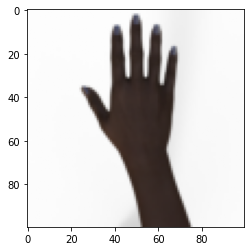

In [ ]:
predict('/content/drive/MyDrive/RPS/data/validation/paper-hires1.png')